In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

df = pd.read_csv('../datasets/students_simple.csv')
N = 1
col_1 = N % 5
col_2 = (N ** 2) % 5 + 5
x = df.iloc[:, col_1]
print(x)
y = df.iloc[:, col_2]
print(y)


0     45
1     61
2     56
3     48
4     54
5     58
6     51
7     62
8     70
9     72
10    73
11    64
12    73
13    68
14    81
15    84
16    76
17    90
18    68
19    95
Name: mass, dtype: int64
0     3.533
1     2.623
2     2.875
3     3.375
4     3.000
5     2.828
6     3.255
7     2.726
8     2.429
9     2.361
10    2.342
11    2.672
12    2.356
13    2.559
14    2.173
15    2.095
16    2.342
17    2.011
18    2.691
19    2.021
Name: bmi, dtype: float64


In [ ]:
# I
# Считаем корреляцию Фехнера
def fechner_correlation(x, y):
    x_sign = np.sign(x-np.mean(x))
    y_sign = np.sign(y-np.mean(y))
    C = np.sum(x_sign == y_sign)
    H = np.sum(x_sign != y_sign)
    fechner = (C - H) / len(x)
    return fechner
fechner_corr = fechner_correlation(x, y)
print(f"Корреляция Фехнера: {fechner_corr:.2f}")

# сравниваеv направление отклонений относительно средних значений
# область значений у коэффициентов от -1 до 1, по корреляции фехнера видим, что близко к -1
# значит чем больше один показатель, тем меньше другой

Корреляция Фехнера: -0.90


In [3]:
# Считаем корреляцию Пирсона ручками и сверяем со встроенной функцией, а еще доверительный интервал
pearson_corr, p_value = stats.pearsonr(x, y)
def pearson_correlation(x, y):
    covariance = sum((x_i - np.mean(x)) * (y_i - np.mean(y)) for x_i, y_i in zip(x, y))/len(x)
    std_x = ((sum((x_i - np.mean(x)) ** 2 for x_i in x))/(len(x)-1)) ** 0.5
    std_y = ((sum((y_i - np.mean(y)) ** 2 for y_i in y))/(len(x)-1)) ** 0.5
    return covariance / (std_x * std_y)
corr_alt = pearson_correlation(x, y)

n = len(x)
z = np.arctanh(pearson_corr)
se = 1 / np.sqrt(n - 3)
z_lower = z - 1.96 * se
z_upper = z + 1.96 * se

pearson_lower = np.tanh(z_lower)
pearson_upper = np.tanh(z_upper)

print(f"Встроенная корреляция Пирсона: {pearson_corr:.4f}")
print(f"По формуле корреляция Пирсона: {corr_alt:.4f}")
print(f"Доверительный интервал Пирсона: [{pearson_lower:.4f}, {pearson_upper:.4f}]")

# по полученным данным корреляции также видим сильно значимую отрицательную корреляцию
# доверительный интервал это подтверждает, у нас все значения отрицательные и близки к -1
# то есть когда растет один показатель, другой уменьшается
# 

Встроенная корреляция Пирсона: -0.9606
По формуле корреляция Пирсона: -0.9126
Доверительный интервал Пирсона: [-0.9846, -0.9012]


In [4]:
# Считаем корреляцию Спирмена ручками и встроенную
spearman_corr, _ = stats.spearmanr(x, y)
def spearman_correlation(x, y):
    n = len(x)
    ranks_x = stats.rankdata(x)
    ranks_y = stats.rankdata(y)
    d_squared_sum = 0
    for i in range(n):
        d_squared_sum += (ranks_x[i] - ranks_y[i]) ** 2
    spearman_rho = 1 - (6 * d_squared_sum) / (n * (n ** 2 - 1))
    return spearman_rho
corr_sp = spearman_correlation(x, y)
print(f"Встроенная корреляция Спирмена: {spearman_corr:.4f}")
print(f"По формуле корреляция Cпирмена: {corr_sp:.4f}")
# снова убеждаемся в значимости отрицательной корреляции

Встроенная корреляция Спирмена: -0.9849
По формуле корреляция Cпирмена: -0.9827


In [5]:
# Считаем корреляцию Кенделла встроенную и ручками
kendall_corr, _ = stats.kendalltau(x, y)
def kendall_correlation(x, y):
    n = len(x)
    discordant = 0
    for i in range(n):
        for j in range(i + 1, n):
            x_order = (x[i] < x[j])  
            y_order = (y[i] < y[j])  
            if x_order != y_order: 
              discordant += 1
    K = 1 - (4 * discordant) / (n * (n - 1))
    return K
corr_ken = kendall_correlation(x, y)
print(f"Встроенная корреляция Кенделла: {kendall_corr:.4f}")
print(f"По формуле корреляция Кенделла: {corr_ken:.4f}")

Встроенная корреляция Кенделла: -0.9390
По формуле корреляция Кенделла: -0.9474


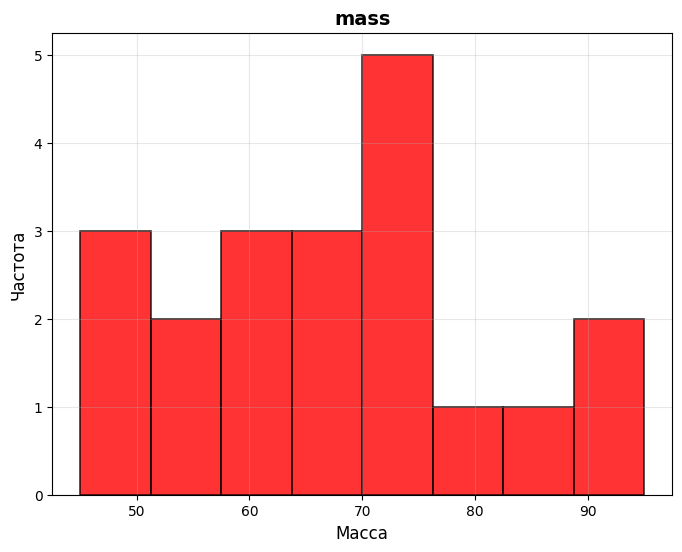

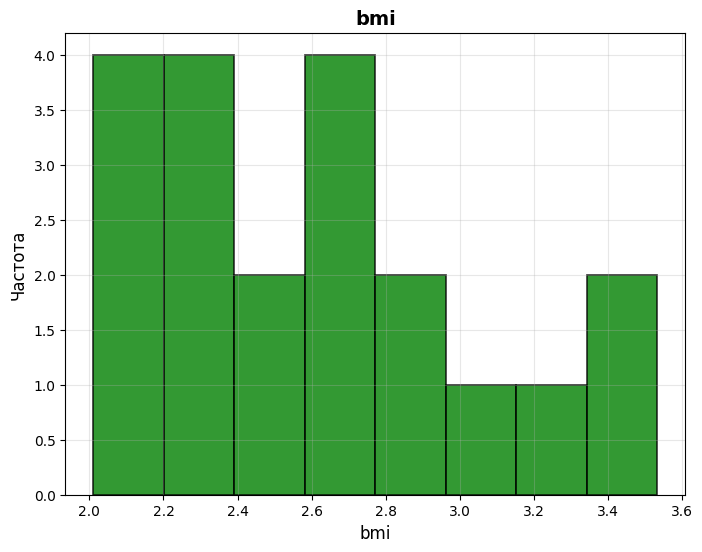

In [6]:
# II
# Гистограммы
plt.figure(figsize=(8, 6))
plt.hist(x, bins=8, color='red', alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('mass', fontsize=14, fontweight='bold')
plt.xlabel('Масса', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(y, bins=8, color='green', alpha=0.8, edgecolor='black', linewidth=1.2)
plt.title('bmi', fontsize=14, fontweight='bold')
plt.xlabel('bmi', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


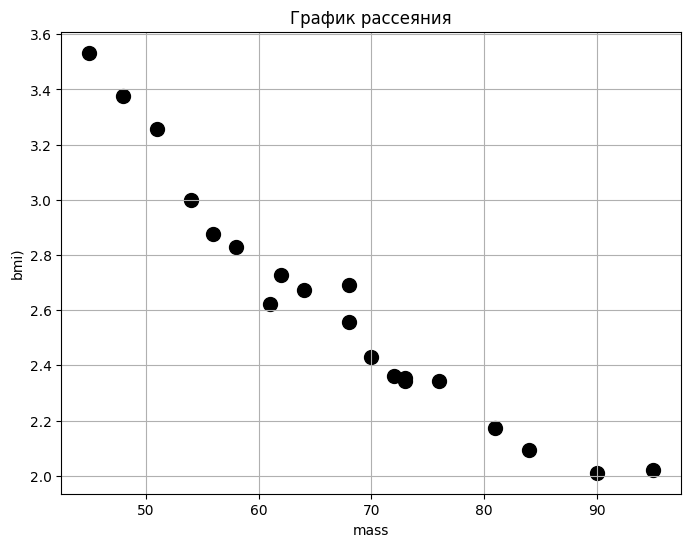

In [7]:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, s=100, color='black')
plt.title('График рассеяния')
plt.xlabel('mass')
plt.ylabel('bmi)')
plt.grid(True)
plt.show()

In [8]:
# III
# Линейная
sum_x = np.sum(x)
sum_y = np.sum(y)
sum_xy = np.sum(x * y)
sum_x2 = np.sum(x**2)
sum_y2 = np.sum(y**2)
w1 = (n * sum_xy - sum_x * sum_y) / (n * sum_x2 - sum_x**2)
w0 = (sum_y - w1 * sum_x) / n
print(f"1. Линейная: y = {w1:.4f}·x + {w0:.4f}")

# 2. Квадратичная
sum_x3 = np.sum(x**3)
sum_x4 = np.sum(x**4)
sum_x2y = np.sum(x**2 * y)
A = np.array([
    [n, sum_x, sum_x2],
    [sum_x, sum_x2, sum_x3],
    [sum_x2, sum_x3, sum_x4]
])
B = np.array([sum_y, sum_xy, sum_x2y])
coef_quad = np.linalg.solve(A, B)
w0_quad, w1_quad, w2_quad = coef_quad
print(f"2. Квадратичная: y = {w2_quad:.4f}·x² + {w1_quad:.4f}·x + {w0_quad:.4f}")

# 3. Гиперболическая
u = 1 / x
sum_u = np.sum(u)
sum_u2 = np.sum(u**2)
sum_uy = np.sum(u * y)
w1_h = (n * sum_uy - sum_u * sum_y) / (n * sum_u2 - sum_u**2)
w0_h = (sum_y - w1_h * sum_u) / n
print(f"3. Гиперболическая: y = {w1_h:.4f}/x + {w0_h:.4f}")

# 4. Показательная
log_y = np.log(y)
sum_x_logy = np.sum(x * log_y)
sum_logy = np.sum(log_y)
a = (n * sum_x_logy - sum_x * sum_logy) / (n * sum_x2 - sum_x**2)
b = (sum_logy - a * sum_x) / n
w1_exp = np.exp(a)
w0_exp = np.exp(b)
print(f"4. Показательная: y = {w0_exp:.4f}·{w1_exp:.4f}ˣ")

# все модели подтверждают сильную отрицательную зависимость между массой тела и ИМТ
# квадратичная модель кажется наилучшей так как к тому же учитывает нелинейность

1. Линейная: y = -0.0308·x + 4.6881
2. Квадратичная: y = 0.0005·x² + -0.0990·x + 6.9596
3. Гиперболическая: y = 135.2427/x + 0.5275
4. Показательная: y = 5.6857·0.9884ˣ


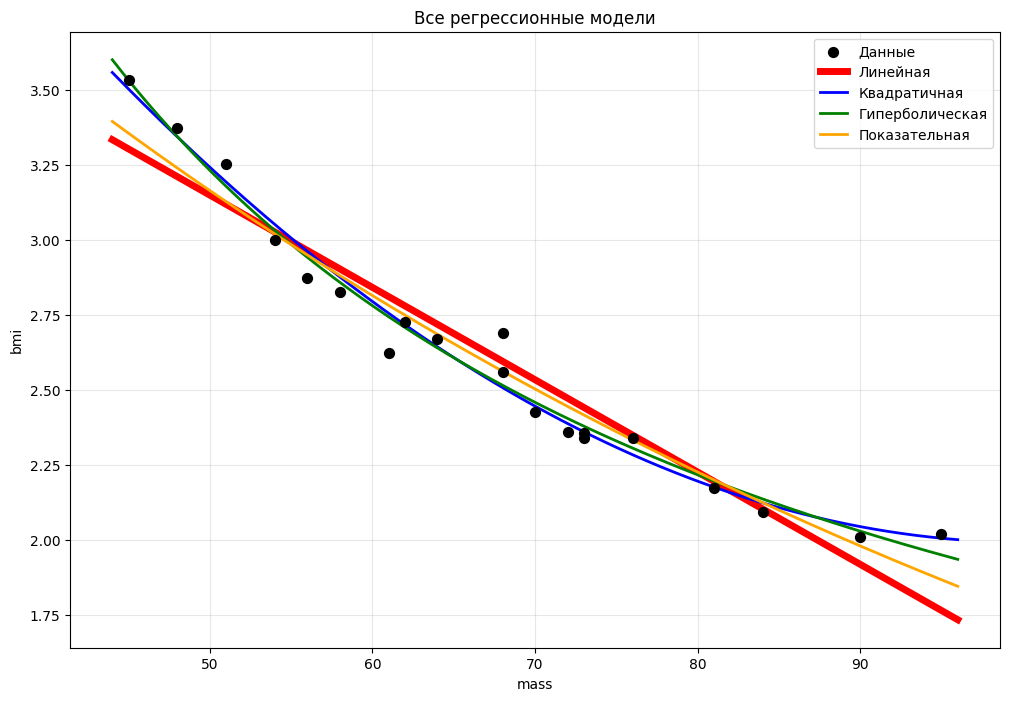

In [9]:
x_smooth = np.linspace(x.min() - 1, x.max() +1, 300)
y_lin = w1 * x_smooth + w0
y_quad = w2_quad * x_smooth**2 + w1_quad * x_smooth + w0_quad
y_hyper = w1_h / x_smooth + w0_h
y_exp = w0_exp * (w1_exp ** x_smooth)

plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='black', s=50, label='Данные', zorder=5)
plt.plot(x_smooth, y_lin, 'red', linewidth=5, label='Линейная')
plt.plot(x_smooth, y_quad, 'blue', linewidth=2, label='Квадратичная')
plt.plot(x_smooth, y_hyper, 'green', linewidth=2, label='Гиперболическая')
plt.plot(x_smooth, y_exp, 'orange', linewidth=2, label='Показательная')
plt.xlabel('mass')
plt.ylabel('bmi')
plt.title('Все регрессионные модели')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [10]:
from scipy.stats import f

y_pred_lin = w1 * x + w0 
y_pred_quad = w2_quad * x**2 + w1_quad * x + w0_quad
y_pred_hyper = w1_h / x + w0_h  
y_pred_exp = w0_exp * (w1_exp ** x) 

models_info = [
    ('Линейная', y_pred_lin, 2),           
    ('Квадратичная', y_pred_quad, 3),      
    ('Гиперболическая', y_pred_hyper, 2),  
    ('Показательная', y_pred_exp, 2)       
]

def statistic(y_true, y_pred, k):
    n = len(y_true)
    numer = np.sum((y_true - y_pred)**2)
    deter = np.sum((y_true - np.mean(y_true))**2)
    R2 = 1 - numer / deter
    F = (R2 / (1 - R2)) * ((n - k) / (k - 1))
    return R2, F

results = []
for name, y_pred, k in models_info:
    R2, F = statistic(y, y_pred, k)
    results.append((name, R2, F, k))

results.sort(key=lambda x: x[1], reverse=True)
for name, R2, F, k in results:
    print(f"{name:15} | R² = {R2:8.4f} | F = {F:8.4f} | k: {k}")

best_model = results[0]
worst_model = results[-1]
for name, R2, F, k in [best_model, worst_model]:
    F_critical = f.ppf(0.95, k - 1, n - k)
    print(f"{name}:")
    print(f"  F = {F:.4f}")
    print(f"  Fкрит = {F_critical:.4f}")
    
    if F > F_critical:
        print(f"ОТВЕРГАЕМ НУЛЕВУЮ ГИПОТЕЗУ")
        print(f"МОДЕЛЬ ЗНАЧИМА")
    else:
        print(f"ПРИНИМАЕМ НУЛЕВУЮ ГИПОТЕЗУ")  
        print(f"МОДЕЛЬ НЕ ЗНАЧИМА")
    print()

Гиперболическая | R² =   0.9791 | F = 844.5955 | k: 2
Квадратичная    | R² =   0.9779 | F = 376.6424 | k: 3
Показательная   | R² =   0.9542 | F = 375.3458 | k: 2
Линейная        | R² =   0.9228 | F = 215.0718 | k: 2
Гиперболическая:
  F = 844.5955
  Fкрит = 4.4139
ОТВЕРГАЕМ НУЛЕВУЮ ГИПОТЕЗУ
МОДЕЛЬ ЗНАЧИМА

Линейная:
  F = 215.0718
  Fкрит = 4.4139
ОТВЕРГАЕМ НУЛЕВУЮ ГИПОТЕЗУ
МОДЕЛЬ ЗНАЧИМА

